In [4]:
%load_ext autoreload
%autoreload 2
from propensity_with_density import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import math
from true_overlap_scipy import *

seed = int(np.random.rand() * (2**32 - 1))

seed = 0

np.random.seed(seed)
print("Seed: " + str(seed))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Seed: 0


Test predict() function

In [5]:
def sample_normal(mean1, mean2, sd1, sd2, n, m):
    x1 = np.random.normal(mean1, sd1, (n, m))
    x2 = np.random.normal(mean2, sd2, (n, m))

    return x1, x2

def sample_normal_2_means(mean1, mean2, sd1, sd2, n, m):
    x1 = np.random.normal(mean1, sd1, (n, m))

    bool_array = np.random.choice([0, 1], size=(n,1))
    region1 = np.random.normal(-mean2, sd2, (n, m))
    region2 = np.random.normal(mean2, sd2, (n, m))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x2 = region1 * bool_matrix + region2 * (1 - bool_matrix)
    return x1, x2

def sample_uniform_2_means(l1, r1, mean2, sd2, n, m):
    x1 = np.random.uniform(l1, r1, (n, m))

    bool_array = np.random.choice([0, 1], size=(n,1))
    region1 = np.random.normal(-mean2, sd2, (n, m))
    region2 = np.random.normal(mean2, sd2, (n, m))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x2 = region1 * bool_matrix + region2 * (1 - bool_matrix)
    return x1, x2

def sample_normal_outliers(mean1, mean2, sd1, sd2, n, m, outlier_chance, outliermean):
    true_samples1, true_samples2 = sample_normal(mean1, mean2, sd1, sd2, n, m)
    outliers1, outliers2 = sample_normal(outliermean, outliermean, sd1, sd2, n, m)
    bool_array = np.random.choice([0, 1], p=[outlier_chance, 1-outlier_chance], size=(n,1))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x1 = true_samples1 * bool_matrix + outliers1 * (1 - bool_matrix)
    x2 = true_samples2 * bool_matrix + outliers2 * (1 - bool_matrix)
    # binary matrix which indicates which samples are non-outliers (with 1 being non-outlier)
    non_outlier_matrix = np.concatenate([bool_matrix, bool_matrix]).reshape(-1, m)
    return x1, x2, non_outlier_matrix

def sample_normal_2_separate(mean1, mean2, sd1, sd2, n, m):
    bool_array = np.random.choice([0, 1], size=(n,1))
    region1 = np.random.normal(-mean1, sd1, (n, m))
    region2 = np.random.normal(mean1, sd1, (n, m))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x1 = region1 * bool_matrix + region2 * (1 - bool_matrix)

    bool_array = np.random.choice([0, 1], size=(n,1))
    region1 = np.random.normal(-mean2, sd2, (n, m))
    region2 = np.random.normal(mean2, sd2, (n, m))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x2 = region1 * bool_matrix + region2 * (1 - bool_matrix)
    return x1, x2

def sample_uniform(n, m):
    x1 = np.random.uniform(0, 5, (n, m))
    x2 = np.random.uniform(2, 3, (n, m))
    return x1, x2

In [6]:
epsilon =  0.05
alpha = epsilon
N_samples = 500
dim = 1

# if use LogisticRegression
classifier = "lr"
# if use DecisionTreeClassifier
# classifier = "dtc"
# if use RandomForestClassifier
# classifier = "rfc"

# mean2 = 0.2
# sd1 = 1.0
# sd2 = 1.0
mean1 = 0
mean2 = 3.1
sd1 = 2.0/dim
sd2 = 1.4/dim

# 1 region of overlap
# x1, x2 = sample_normal(0, mean2, sd1, sd2, N_samples, dim)

# 2 regions of overlap
x1, x2 = sample_normal_2_means(0, mean2, sd1, sd2, N_samples, dim)

# outliers added
# outlier_chance = 0.025
# x1, x2 = sample_normal_outliers(0, mean2, sd1, sd2, N_samples, dim, 0.05, 5)
# x1, x2, non_outlier_matrix = sample_normal_outliers(0, mean2, sd1, sd2, N_samples, dim, outlier_chance, 5)

# 2 regions with a uniform distribution
# r1 = 2
# l1 = -r1
# x1, x2 = sample_uniform_2_means(l1, r1, mean2, sd2, N_samples, dim)

# 2 separate regions
# x1, x2 = sample_normal_2_separate(mean1, mean2, sd1, sd2, N_samples, dim)

In [7]:
X = np.concatenate([x1, x2]).reshape(-1, dim)
y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

propensity = PropensityDensity(classifier, alpha)
propensity.tune_hyperparameters(classifier, X, y)
prediction = propensity.predict(X)

predicted_overlap_samples = propensity.get_overlap_samples(X)

In [8]:
mean1_array = np.ones(dim) * mean1
mean2_array = np.ones(dim) * mean2
cov1 = np.diag(np.ones(dim) * sd1)
cov2 = np.diag(np.ones(dim) * sd2)
# which true overlap depends on which scenario
# true_overlap_labels = check_true_overlap(mean1_array, mean2_array, cov1, cov2, x1, x2, epsilon, dim).astype(int)
true_overlap_labels = check_true_overlap_2_regions(mean1_array, mean2_array, cov1, cov2, x1, x2, epsilon, dim).astype(int)
# true_overlap_labels = check_true_overlap_2_regions_separate(mean1_array, mean2_array, cov1, cov2, x1, x2, epsilon, dim).astype(int)
# true_overlap_labels = check_true_overlap_2_regions_uniform(l1, r1, mean2_array, cov2, x1, x2, epsilon, dim).astype(int)
print("% of samples in overlap region: "+ str(true_overlap_labels.sum()/ float(N_samples * 2)))

accuracy = propensity.score(X, true_overlap_labels, score_type="accuracy")
print("accuracy: "+ str(accuracy))

iou = propensity.score(X, true_overlap_labels, score_type="iou")
print("IoU: "+ str(iou))

% of samples in overlap region: 0.305
accuracy: 0.377
IoU: 0.3286637931034483


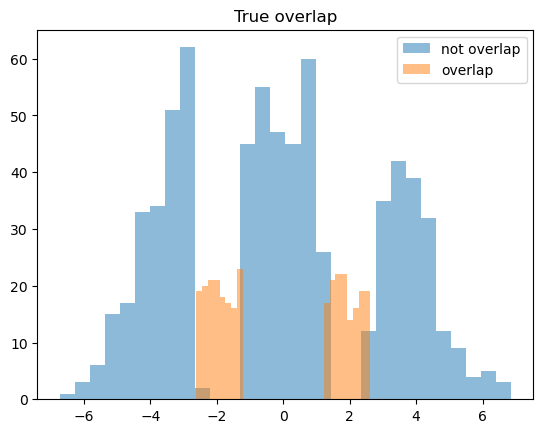

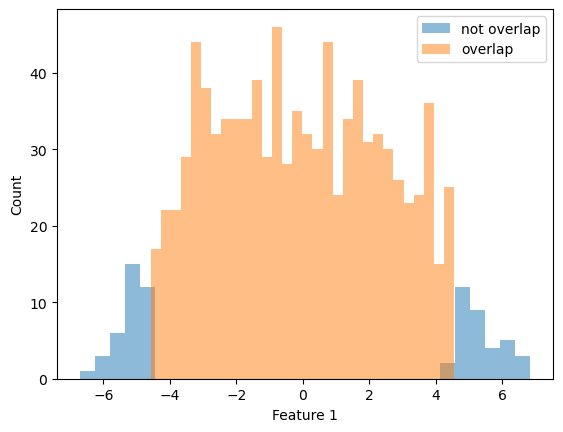

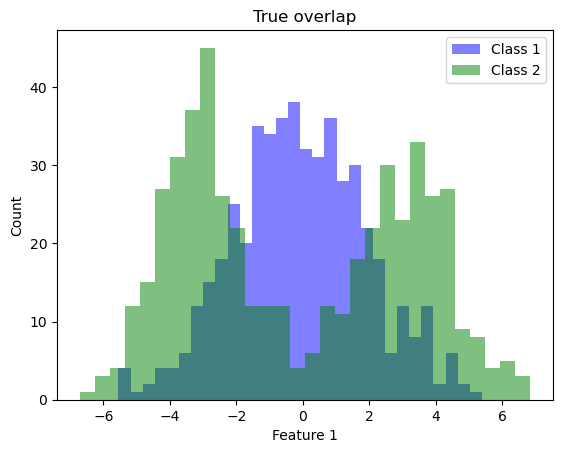

C:\Users\jkkt3\anaconda3\lib\site-packages\matplotlib\patches.py:1074: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


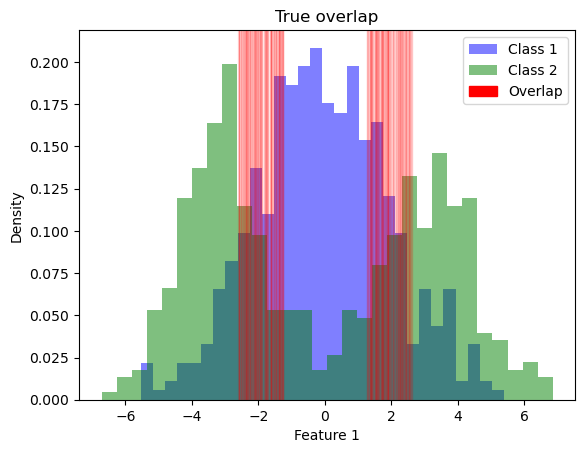

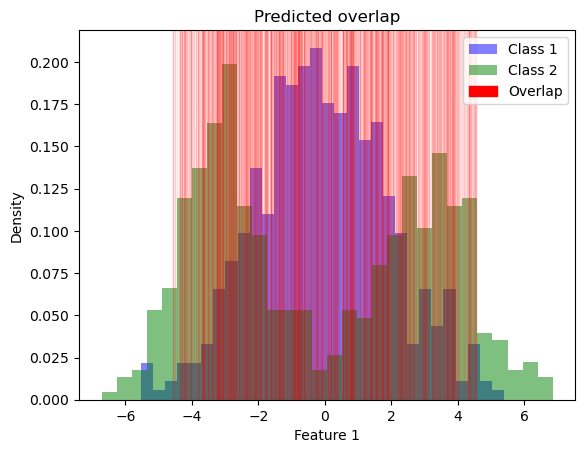

In [9]:
overlapped_samples = X[true_overlap_labels.astype(bool)]
overlap_x1 = x1[true_overlap_labels[:N_samples].astype(bool)]
overlap_x2 = x2[true_overlap_labels[N_samples:].astype(bool)]
overlap_patch = patch.Patch(color='red', label='Overlap')


# plot in 2D and 1D
if dim == 2:
    not_in_overlap = np.array([x for x in X if x not in overlapped_samples])

    # =========== show two distributions true overlap

    # overlap_x1 = true_overlap.get_overlapped_data(x1, np.array([], dtype=np.int64).reshape(0,2))
    non_overlap_x1 = np.array([x for x in x1 if x not in overlap_x1])
    # overlap_x2 = true_overlap.get_overlapped_data(x2, np.array([], dtype=np.int64).reshape(0,2))
    non_overlap_x2 = np.array([x for x in x2 if x not in overlap_x2])

    plt.figure(7)
    # plt.scatter(non_overlap_x1[:,0], non_overlap_x1[:,1], c="blue", marker=".")
    # plt.scatter(overlap_x1[:,0], overlap_x1[:,1], c="red", marker=".")
    # plt.scatter(non_overlap_x2[:,0], non_overlap_x2[:,1], c="green", marker=".")
    # plt.scatter(overlap_x2[:,0], overlap_x2[:,1], c="red", marker=".")
    scatter_nonoverlap1 = plt.scatter(non_overlap_x1[:,0], non_overlap_x1[:,1], c="blue")
    plt.scatter(overlap_x1[:,0], overlap_x1[:,1], c="red")
    scatter_nonoverlap2 = plt.scatter(non_overlap_x2[:,0], non_overlap_x2[:,1], c="green")
    scatter_overlap = plt.scatter(overlap_x2[:,0], overlap_x2[:,1], c="red")
    plt.title("True overlap")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend((scatter_nonoverlap1, scatter_nonoverlap2, scatter_overlap),
           ('Non-overlap class 1', 'Non-overlap class 2', 'Overlap'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=8)

    plt.show()

    # ======= predicted overlap

    # predicted_not_in_overlap = np.array([x for x in X if x not in predicted_overlap_samples])
    non_overlap_x1 = np.array([x for x in x1 if x not in predicted_overlap_samples])
    non_overlap_x2 = np.array([x for x in x2 if x not in predicted_overlap_samples])

    plt.figure(6)
    # if predicted_not_in_overlap.ndim == 2:
    #   scatter_nonoverlap = plt.scatter(predicted_not_in_overlap[:,0], predicted_not_in_overlap[:,1], c="blue")
    scatter_nonoverlap1 = plt.scatter(non_overlap_x1[:,0], non_overlap_x1[:,1], c="blue")
    scatter_nonoverlap2 = plt.scatter(non_overlap_x2[:,0], non_overlap_x2[:,1], c="green")
    scatter_overlap = plt.scatter(predicted_overlap_samples[:,0], predicted_overlap_samples[:,1], c="red")
    plt.title("Predicted overlap")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend((scatter_nonoverlap1, scatter_nonoverlap2, scatter_overlap),
           ('Non-overlap class 1', 'Non-overlap class 2', 'Overlap'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=8)
    plt.show()

if dim == 1:
    not_in_overlap = np.array([x for x in X if x not in overlapped_samples])


    plt.figure(5)
    plt.hist(not_in_overlap[:,0], bins=30, alpha=0.5, label='not overlap')
    plt.hist(overlapped_samples[:,0], bins=30, alpha=0.5, label='overlap')
    plt.title("True overlap")
    plt.legend()
    plt.show()

    predicted_not_in_overlap = np.array([x for x in X if x not in predicted_overlap_samples])

    plt.figure(6)
    plt.hist(predicted_not_in_overlap[:,0], bins=30, alpha=0.5, label='not overlap')
    plt.hist(predicted_overlap_samples[:,0], bins=30, alpha=0.5, label='overlap')
    plt.xlabel('Feature 1')
    plt.ylabel('Count')
    plt.legend()

    plt.figure(5)
    # plt.hist(overlapped_samples[:,0], bins=30, alpha=0.5, label='not overlap', density=True)
    nonoverlap1 = plt.hist(x1[:,0], bins=30, alpha=0.5, label='Class 1', color='blue')
    nonoverlap2 = plt.hist(x2[:,0], bins=30, alpha=0.5, label='Class 2', color='green')
    plt.title("True overlap")
    plt.xlabel('Feature 1')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    plt.figure(5)
    # plt.hist(overlapped_samples[:,0], bins=30, alpha=0.5, label='not overlap', density=True)
    nonoverlap1 = plt.hist(x1[:,0], bins=30, alpha=0.5, label='Class 1', color='blue', density=True)
    nonoverlap2 = plt.hist(x2[:,0], bins=30, alpha=0.5, label='Class 2', color='green', density=True)
    # plt.axvspan(overlapped_samples.min(), overlapped_samples.max(), alpha=0.4, color='gray', label='Overlap')
    for s in overlapped_samples:
        plt.axvspan(s, s, alpha=0.1, color='red')
    plt.title("True overlap")
    plt.xlabel('Feature 1')
    plt.ylabel('Density')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(overlap_patch)
    plt.legend(handles=handles)
    plt.show()

    predicted_not_in_overlap = np.array([x for x in X if x not in predicted_overlap_samples])

    plt.figure(6)
    # plt.hist(predicted_not_in_overlap[:,0], bins=30, alpha=0.5, label='not overlap', density=True)
    # plt.hist(predicted_overlap_samples[:,0], bins=30, alpha=0.5, label='overlap', density=True)
    nonoverlap1 = plt.hist(x1[:,0], bins=30, alpha=0.5, label='Class 1', color='blue', density=True)
    nonoverlap2 = plt.hist(x2[:,0], bins=30, alpha=0.5, label='Class 2', color='green', density=True)
    # plt.axvspan(predicted_overlap_samples.min(), predicted_overlap_samples.max(), alpha=0.4, color='gray', label='Overlap')
    plt.title("Predicted overlap")
    for s in predicted_overlap_samples:
        plt.axvspan(s, s, alpha=0.1, color='red')
    plt.xlabel('Feature 1')
    plt.ylabel('Density')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(overlap_patch)
    plt.legend(handles=handles)

    # plt.figure(7)
    # plt.hist(full_x1.T[i], bins=200, alpha=0.5, label='x1', density=True)
    # plt.hist(full_x2.T[i], bins=200, alpha=0.5, label='x2', density=True)
    # plt.axhline(epsilon, color='red', linestyle='--', label='epsilon')

    plt.show()

if dim == 3:
    not_in_overlap = np.array([x for x in X if x not in overlapped_samples])

    plt.figure(5)
    ax = plt.axes(projection='3d')
    xdata = not_in_overlap[:,0]
    ydata = not_in_overlap[:,1]
    zdata = not_in_overlap[:,2]
    # scatter_nonoverlap = ax.scatter3D(xdata, ydata, zdata, color= "blue", edgecolors= "black")

    xdata = overlapped_samples[:,0]
    ydata = overlapped_samples[:,1]
    zdata = overlapped_samples[:,2]
    scatter_overlap = ax.scatter3D(xdata, ydata, zdata, color= "red", edgecolors= "black")
    plt.title("True overlap")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.show()

    predicted_not_in_overlap = np.array([x for x in X if x not in predicted_overlap_samples])

    plt.figure(6)
    ax = plt.axes(projection='3d')
    xdata = predicted_not_in_overlap[:,0]
    ydata = predicted_not_in_overlap[:,1]
    zdata = predicted_not_in_overlap[:,2]
    scatter_nonoverlap = ax.scatter3D(xdata, ydata, zdata, color= "blue", edgecolors= "black")

    xdata = predicted_overlap_samples[:,0]
    ydata = predicted_overlap_samples[:,1]
    zdata = predicted_overlap_samples[:,2]
    scatter_overlap = ax.scatter3D(xdata, ydata, zdata, color= "red", edgecolors= "black")
    plt.title("Predicted overlap")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.show()


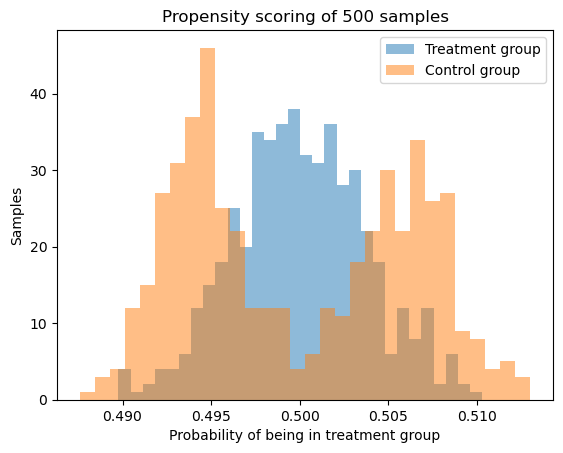

In [10]:
propensity.propensity_plot(x1, x2)